# Grain Size Distribution - Height Correlation Function

Find relevant parameters describing the topography of sputtered Ruthenium thin films on Si substrate
How:
- Roughness RMS
- Fit exponential increase
- Take intersection between RMS asymptote and Fit

Output parameters:
- Roughness
- Correlation Length
- Alpha exponent

In [1]:
import os
import sys

import numpy as np

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from matplotlib import cm
from skimage import data, img_as_float, filters

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

In [2]:
debug = True #or 'False' when you do not want to debug

path = "/Users/sfiligoj/Desktop/Thesis/Data Analysis/AFM/SSP"
# path = "/Users/sfiligoj/Google Drive/Crispies/Ru/Data analysis with Python/Pandas and Matplotlib - HHcorr, Basics and Images/DSP_all"
os.chdir(path)
#files = ['Ru_H_NotA_original.txt','Ru_H_NotA_original_thres.txt']
filess = os.listdir()
filess = [f for f in filess if f.endswith('txt')]
print(f"Found {len(filess)} files")

Found 76 files


In [3]:
#open dictionary of Scan Size values:
with open('ScanSizes.json', 'r') as f:
    ScanSize_dict = json.loads(f.read())

In [4]:
data = dict.fromkeys(filess)
for i,file in enumerate(filess[:]): 
    
    if '*' in file:
        continue
        
    if '_H_' in file:
        density = 'High'
        if 'asdep' in file:
            temperature = 'as-deposited'
        else:
            continue
            temperature = temperature = file[5:9]
        
    elif '_L_' in file:
        density = 'Low'
        if 'asdep' in file:
            temperature = 'as-deposited'
        else:
            continue
            temperature = temperature = file[5:9]

    elif '_LH_' in file:
        density = 'Low-High'
        if 'asdep' in file:
            temperature = 'as-deposited'
        else:
            continue
            temperature = temperature = file[6:10]
        
    print(f'Running file {file}')
    
    data[file] = {}
    
    filesize = os.path.getsize(file)     #to differentiate between 512x512 px or 1024x1024 px img
    Pix_width = int(np.sqrt(filesize/32))
    Pix_height = Pix_width

    output=[]
    
    data[file]['img'] = np.genfromtxt(file, skip_header=1).reshape((Pix_width,Pix_height)) # Retrieve height data from .txt file
    
    AvgHeight = np.mean(data[file]['img'])                            # Should be close to 0 when you have flattened out the image, so it is omittable
    if False: print(f'AvgHeight = {AvgHeight}')
        
    # Variables used in determining the total scan size and step size
    N_Pixel = data[file]['img'].shape[1]                              # before was len(data), which works in this case, but it would be the N of rows 
    if False: 
        print(f'Pixel Number = {N_Pixel}')
    
    ScanSize = ScanSize_dict[file]                       # nm
    StepSize = ScanSize/N_Pixel                         # nm/px     
    # for 512x512 px => step size = 1.95 nm
    # for 1024x1024 px => step size = 0.98 nm
    
        
    # ***    Define Xdelta, the vector of the differences (pos px0 - pos px_n)
    Xdelta = np.linspace(StepSize, ScanSize, num=N_Pixel)

Running file Ru_H_asdep_FLAT.001.txt
Running file Ru_H_asdep_FLAT.003.txt
Running file Ru_H_asdep_1um_FLAT_106.txt
Running file Ru_LH_asdep_FLAT.023.txt
Running file Ru_LH_asdep_FLAT.022.txt
Running file Ru_L_asdep_500nm_FLAT.005.txt
Running file Ru_LH_asdep_FLAT.009.txt
Running file Ru_H_asdep_500nm_FLAT.004.txt
Running file Ru_LH_asdep_500nm_FLAT.008.txt
Running file Ru_H_asdep_200nm_FLAT_111.txt
Running file Ru_H_asdep_FLAT.117.txt
Running file Ru_L_asdep_FLAT.004.txt
Running file Ru_L_asdep_200nm_FLAT.112.txt
Running file Ru_L_asdep_FLAT.000.txt
Running file Ru_L_asdep_FLAT.002.txt
Running file Ru_S_Bare_Si_FLAT.txt


running file:Ru_L_asdep_FLAT.004.txt


/anaconda3/envs/pina/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal


<IPython.core.display.Javascript object>


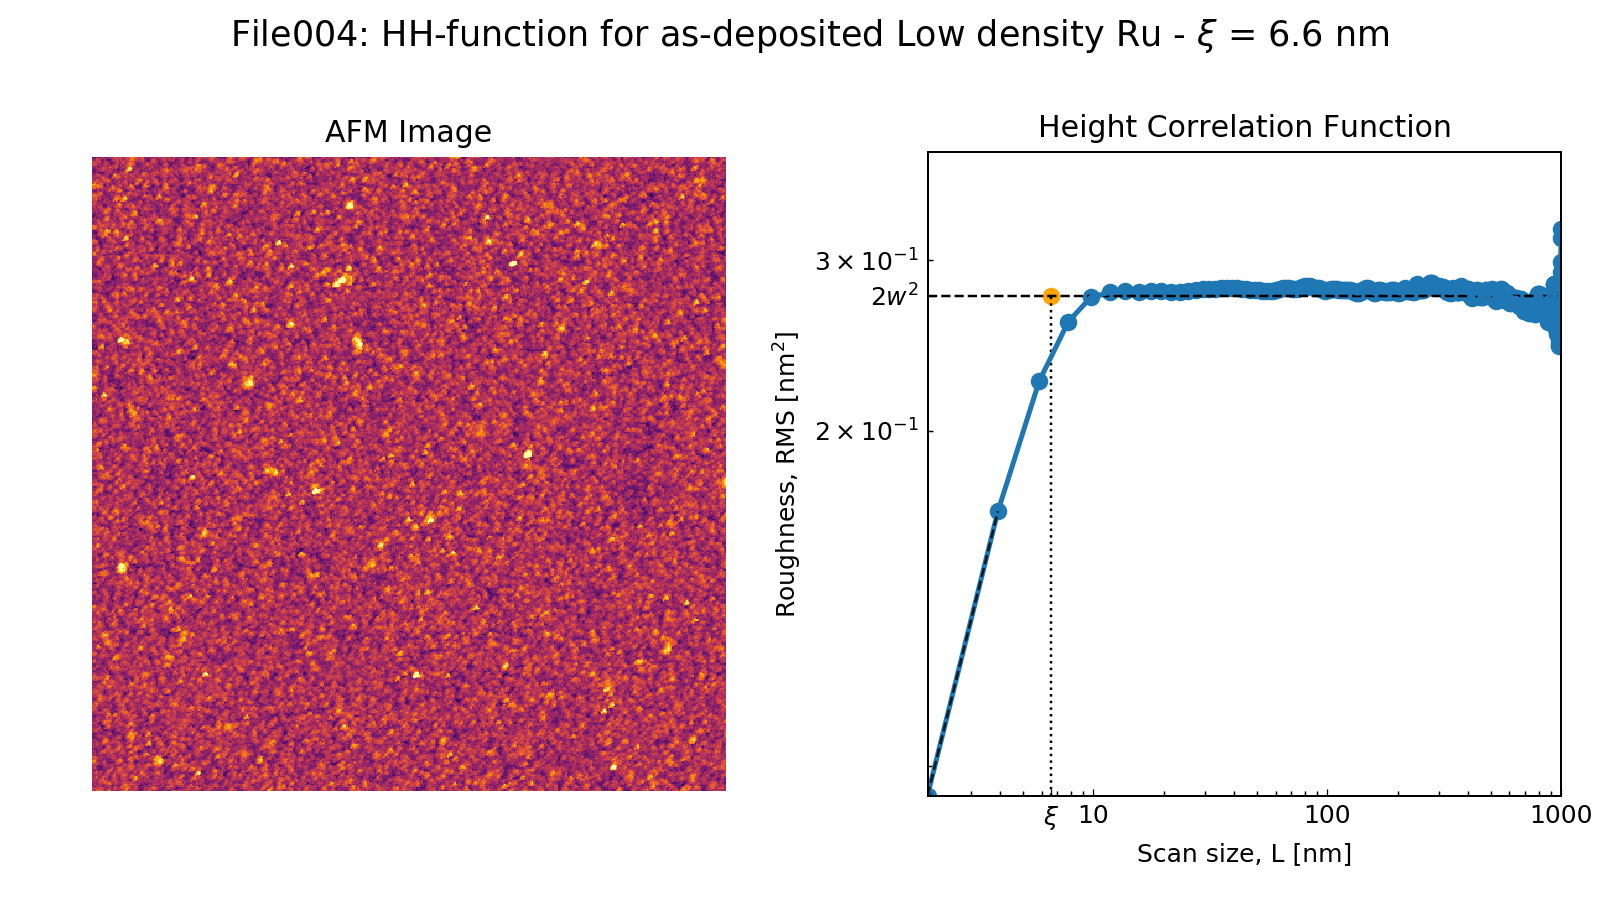

running file:Ru_L_asdep_200nm_FLAT.112.txt


<IPython.core.display.Javascript object>


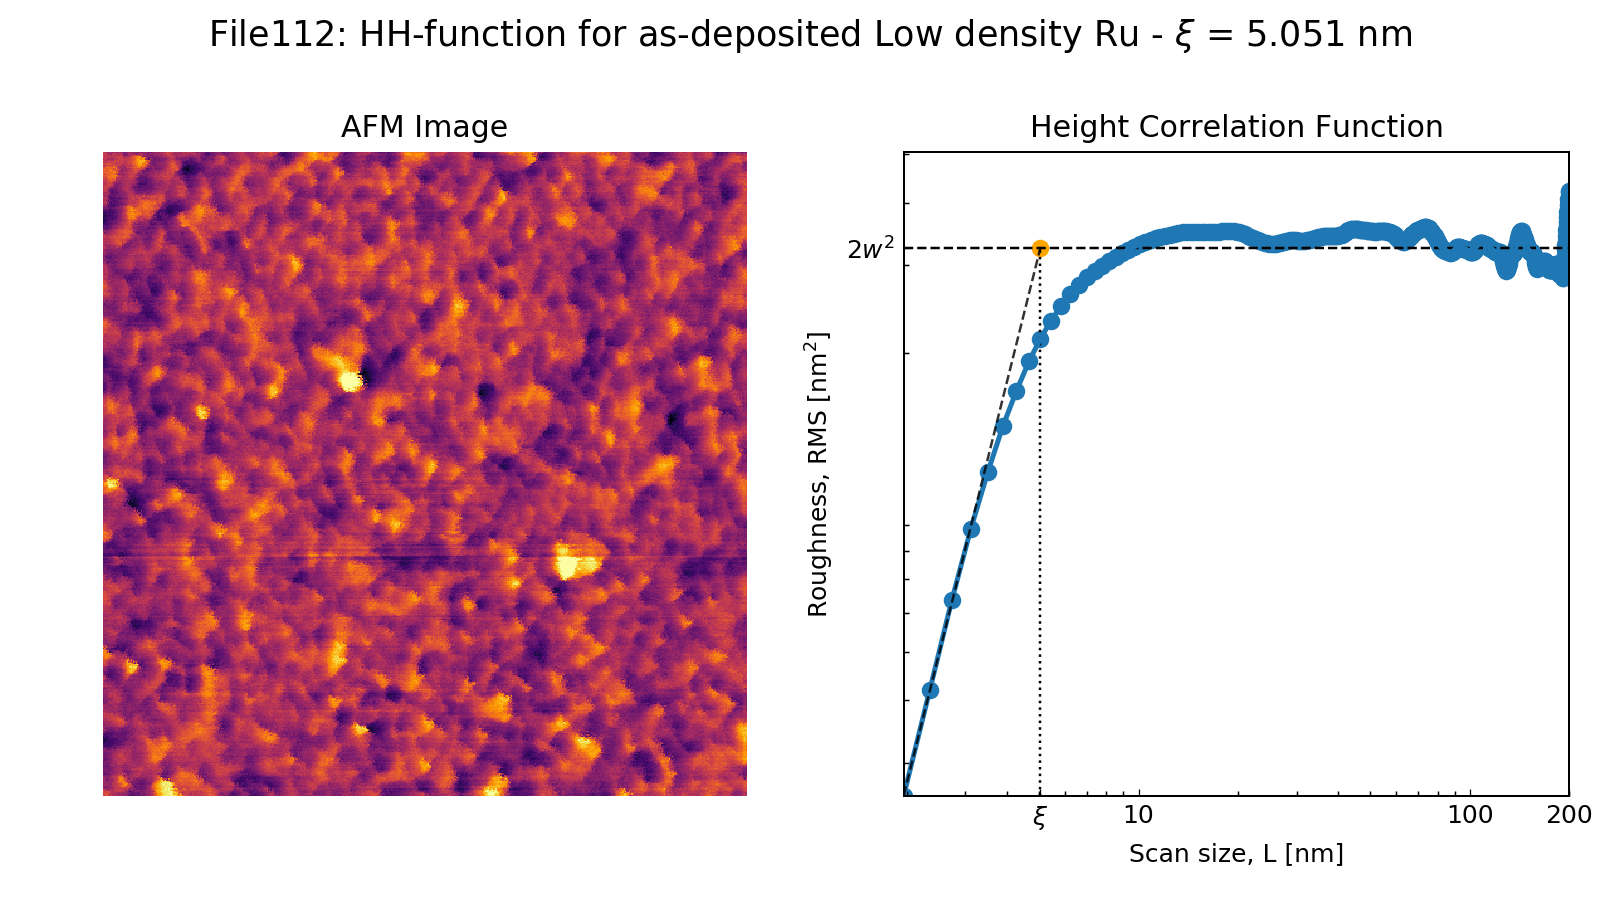

running file:Ru_L_asdep_FLAT.000.txt


<IPython.core.display.Javascript object>


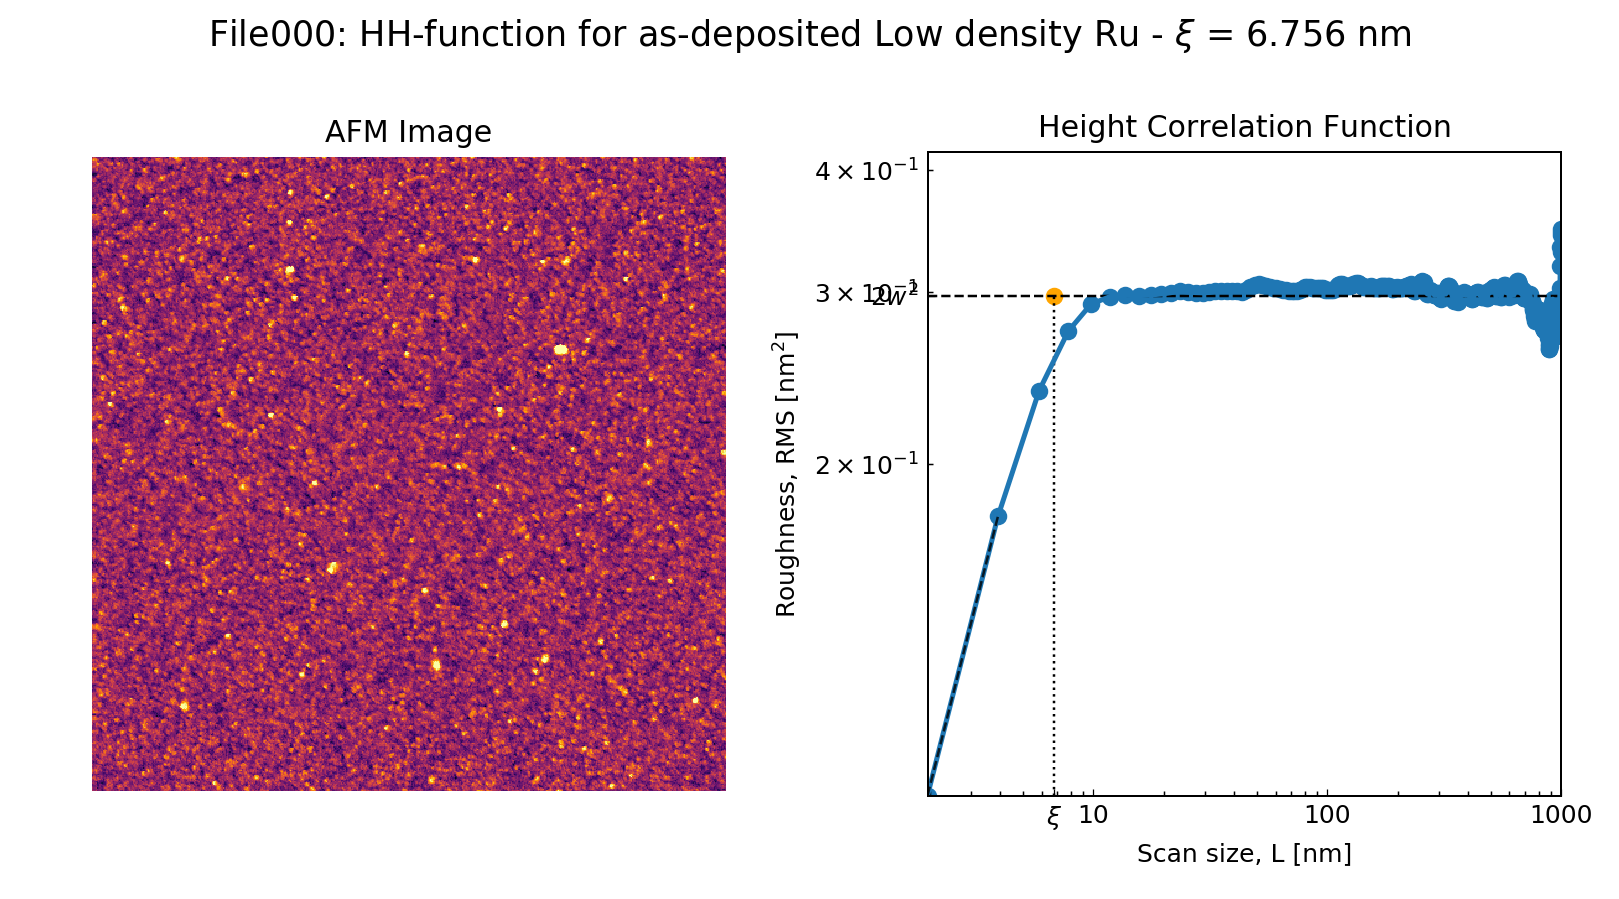

running file:Ru_L_asdep_FLAT.002.txt


<IPython.core.display.Javascript object>


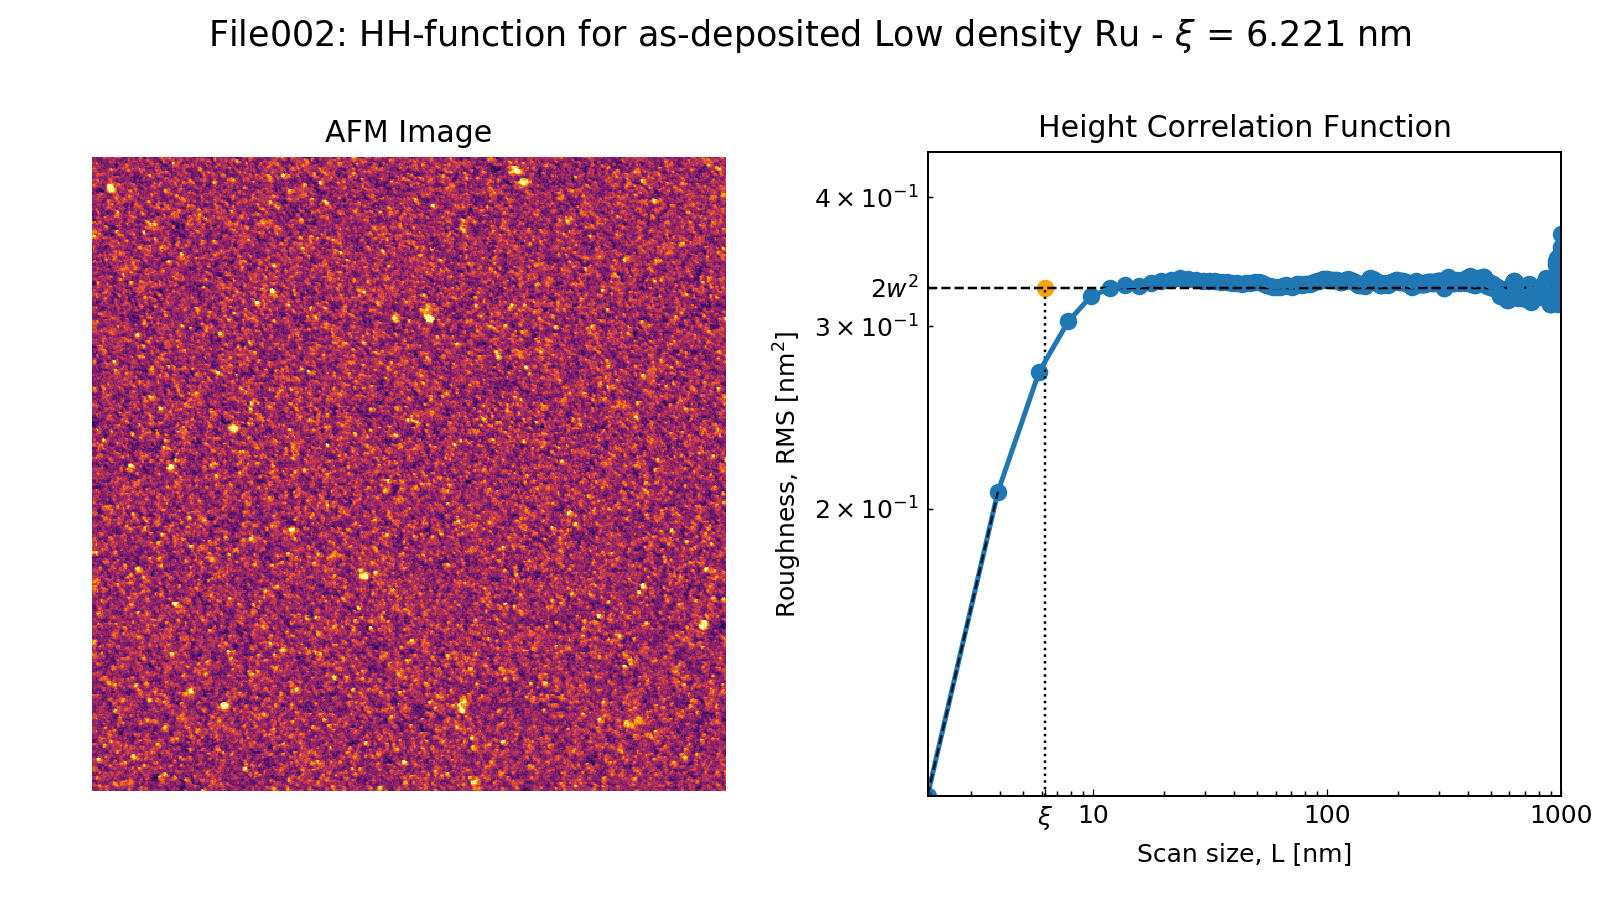

running file:Ru_S_Bare_Si_FLAT.txt


<IPython.core.display.Javascript object>


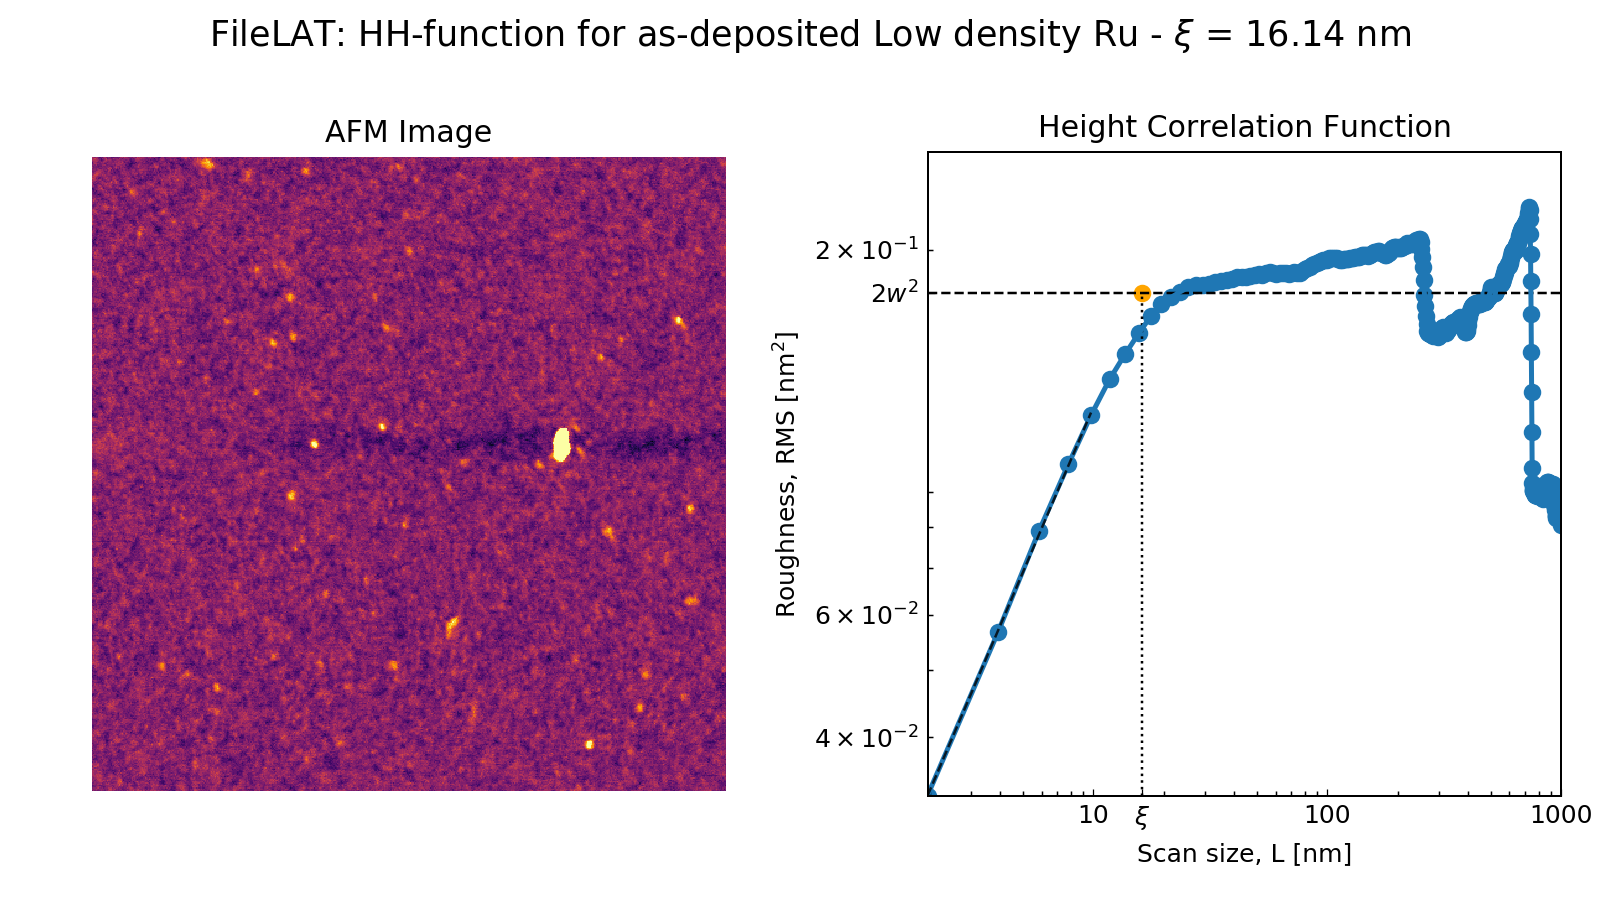

In [19]:
HHcorr=[]
for i,file in enumerate(filess[20:70]):
    
    if '*' in file:
        continue
    
    if '10um' in file:
        continue
        
    if '5um' in file:
        continue
    
#     if '200nm'in file:
#         continue
    
    if '_H_' in file:
        continue
        density = 'High'
        if 'asdep' in file:
            temperature = 'as-deposited'
        else:
            continue
            temperature = temperature = file[5:9]
        
    if '_L_' in file:
        density = 'Low'
        if 'asdep' in file:
            temperature = 'as-deposited'
        else:
            continue
            temperature = temperature = file[5:9]
           
    if '_LH_' in file:
        continue
        density = 'Low-High'
        if 'asdep' in file:
            temperature = 'as-deposited'
        else:
            continue
            temperature = temperature = file[6:10]
    
    print(f'running file:{file}')

    
    # ***    Calculate theoretical asymptotic value of the Height difference correlation: 2w^2   ***
    
    ScanSize = ScanSize_dict[file]                       # nm
    N_Pixel = data[file]['img'].shape[1] 
    Xdelta = np.linspace(StepSize, ScanSize, num=N_Pixel)

    
    HeightSq = (data[file]['img']-AvgHeight)**2                        
    if False: print(f'HeightSq shape = {HeightSq.shape}') #  (should be 512x512)
    RMS_sq = np.mean(HeightSq)               #   RMS^2 = w^2 - also called Interface Width
    if False: print(f'RMS squared = {RMS_sq}')            #  (should be a scalar)
    RMS = np.sqrt(RMS_sq)

    
    #error on the measurements:
#     error_sq = np.sort(sum((np.sqrt(HeightSq) - RMS)**2)/(len(HeightSq)-1))
    
    # ***    Calculate Height-Height correlation function:   ***

    HHcorr = np.zeros(N_Pixel, dtype='float')
    autocorr = np.zeros(N_Pixel, dtype='float')

    for px_dist in range(0, N_Pixel):
        shifted_data = data[file]['img'][:,px_dist+1:].astype(float)
        data_section = data[file]['img'][:,:-px_dist-1].astype(float)
        if False:
            print(f'shifted data= {shifted_data.shape}')
            print(f'sectioned data= {data_section.shape}')
        difference = (data_section-shifted_data)**2
        product = (data_section*shifted_data)
        HHcorr[px_dist] = np.mean(difference)
        autocorr[px_dist]= 2*np.mean(product)
     
        
        
    # ***    Fit the data:   ***
    
    # Consider, as cut-off, 90% of the horizontal asymptote, i.e. 2w^2:
    CutoffPointPLaw = int(np.argwhere(HHcorr>=0.7*2*RMS_sq)[0])
#     CutoffPointPLaw = int(np.argwhere(Xdelta>=6)[0])

    a0=0
    y_err = np.arange(a0,CutoffPointPLaw+a0)
#     y_err = y_err / max(y_err)
    weights = np.exp(y_err)

    
    # ***    Model for describing power law (on log scale):
    
    Model = lambda x, a, alpha: a*x**(2*alpha)
    

    # ***    Fit data using Model
    
    popt, pcov = curve_fit(Model, Xdelta[a0:CutoffPointPLaw+a0], HHcorr[a0:CutoffPointPLaw+a0], 
                           sigma=weights
                           )
  

    # ***    Extracting the correlation length   ***
    
    #*popt= a,alpha
    a = popt[0]                                         # primo parametro dipendente
    alpha = popt[1]                                     # secondo paramtero dipendente
    
    # Equating a*(x**alpha)= 2*RMS_sq you extract x, the correlation length
    CorrLength= (1/a *(2*RMS_sq))**(1/(2*alpha))
    
    
    
    # ***    Plot and save results:
    
    #For all the beautiful colors go to   http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=4
    #                                   &  https://www.quackit.com/css/css_color_codes.cfm
    
    # For axis settings:                 https://matplotlib.org/3.1.0/api/axes_api.html#axis-scales
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (9,5))
    ax = np.ravel(ax)


    AFM = ax[0].imshow(data[file]['img'], cmap = 'inferno', vmax=1.8)
    ax[0].axis('off')
    ax[0].set_title(f"AFM Image")
#     fig.colorbar(AFM, ax=ax[0])
    
    ax[1].loglog(Xdelta, HHcorr, label = 'HH corr', linewidth = 2, alpha=1)
            #and its errors:
            #plt.errorbar(Xdelta, HHcorr, yerr=e, fmt=".")
    ax[1].scatter(Xdelta,HHcorr)
            
    # plot the fit
    ax[1].loglog(Xdelta[:CutoffPointPLaw], Model(Xdelta[:CutoffPointPLaw],*popt), label = 'Fit', linewidth = 1, linestyle='dashed', alpha = 0.8, color ='k')
        
    # show correlation length 
    ax[1].scatter(CorrLength, 2*RMS_sq, marker='o', color='orange')
    ax[1].vlines(CorrLength,HHcorr[0],2*RMS_sq, linestyle="dotted", linewidth=1)
    ax[1].hlines(2*RMS_sq, Xdelta[0], Xdelta[N_Pixel-2], linestyle="dashed",linewidth=1)
        
    # plt.legend()
    ax[1].tick_params(direction='in', length=3, width=0.5, colors='k')
    ax[1].set(xticks=(0,10,CorrLength,100, ScanSize))
    ax[1].set(xticklabels=(0,10,'$\\xi $',100,ScanSize))
    ax[1].set(yticks=(1,2*RMS_sq))
    ax[1].set_yticklabels(('','$2w^2$'))
    ax[1].tick_params(axis='x', which='minor', direction ='in', bottom=True)
    ax[1].tick_params(axis='y', which='minor', direction ='in',labelleft=True)


    ax[1].set(ylabel='Roughness, RMS [nm$^2$]')
    ax[1].set(xlabel='Scan size, L [nm]')
    ax[1].set_title(f"Height Correlation Function")
    
    ax[1].set_xlim(Xdelta[0], ScanSize)
    ax[1].set_ylim(HHcorr[0], 1.2*max(HHcorr))
    
    fig.tight_layout()

    sup_title = f"File{file[-7:-4]}: HH-function for {temperature} {density} density Ru - $\\xi $ = {CorrLength:.4} nm"
    fig.suptitle(sup_title, fontsize=14)
    fig.subplots_adjust(top=0.83)

    figname = f"{sup_title}.png"
    fig.savefig(f'HH function for {temperature} {density} density Ru - {file[-7:-4]}.svg', dpi=600)
    plt.savefig('High density HH function - all.svg', dpi=300)

#     plt.plot(Xdelta, autocorr)
#     plt.xscale('log')


#     #break
#     print('Parameters :')
#     print(f'Roughness = {RMS:.3} nm')                 #  Mean Squared Roughness (should be a scalar)
#     print(f'Correlation Length= {CorrLength:.4} nm')
#     print(f'alpha= {alpha:.4}')

# #     text = open(f'Values for {temperature} {density} density Ruthenium.txt',"a")
# #     text.write(f'\n Filename = {file} \n Scansize = {ScanSize} nm \n Roughness = {RMS:.2} nm \n Correlation length = {CorrLength:.4} nm \n Smoothness alpha = {alpha:.3} \n')
# #     text.close()
    
    
    

#### Simulation of a regular AFM line